# Install Dataset

In [1]:
!gdown "1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96" -O "tumor_dataset.rar"

Downloading...
From: https://drive.google.com/uc?id=1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96
To: /content/tumor_dataset.rar
100% 317M/317M [00:12<00:00, 25.6MB/s]


In [2]:
!pip install unrar -q

In [3]:
!rm -rf "/content/tumor_dataset"
!unrar x "tumor_dataset.rar" &> /dev/null

In [4]:
!ls -l "/content/tumor_dataset/Glioma/" | wc -l
!ls -l "/content/tumor_dataset/Meningioma" | wc -l
!ls -l "/content/tumor_dataset/Pituitary/" | wc -l

1427
709
931


# Imports

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Enable GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('[device]', device)


[device] cuda


# Setup Dataset

In [6]:
# dataset path and image size
# dataset_path = "/content/drive/MyDrive/brain_tumor_dataset/"
dataset_path = "/content/tumor_dataset"
image_size = (224, 224)
# Load and preprocess the dataset
classes = ["Glioma", "Meningioma", "Pituitary"]

images_path = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        images_path.append(image_path)
        labels.append(i)

# Convert the lists to numpy arrays
images_path = np.array(images_path)
labels = np.array(labels)

print('[images_path]', len(images_path), images_path[0], images_path[-1])
print('[labels]', len(labels), labels[:10], labels[-10:])

# Create the train-test split
train_images_path, test_images_path, train_labels, test_labels = train_test_split(images_path, labels, test_size=0.2, stratify=labels, random_state=42)

print('[train_images_path]', len(train_images_path), train_images_path[0], train_images_path[-1])
print('[train_labels]', len(train_labels), train_labels[:10], train_labels[-10:])
print('[test_images_path]', len(test_images_path), test_images_path[0], test_images_path[-1])
print('[test_labels]', len(test_labels), test_labels[:10], test_labels[-10:])


[images_path] 3064 /content/tumor_dataset/Glioma/2.0---MR024780G-i2279.bmp /content/tumor_dataset/Pituitary/3.0---97461-i1400.bmp
[labels] 3064 [0 0 0 0 0 0 0 0 0 0] [2 2 2 2 2 2 2 2 2 2]
[train_images_path] 2451 /content/tumor_dataset/Glioma/2.0---MR024780G-i2885.bmp /content/tumor_dataset/Glioma/2.0---MR051796-i2574.bmp
[train_labels] 2451 [0 0 0 0 0 1 2 0 0 0] [0 2 2 2 0 1 1 2 2 0]
[test_images_path] 613 /content/tumor_dataset/Glioma/2.0---MR051586-i2929.bmp /content/tumor_dataset/Pituitary/3.0---103671-i1325.bmp
[test_labels] 613 [0 0 1 1 1 0 1 0 2 2] [1 1 0 0 2 1 0 0 2 2]


In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_path, labels):
        self.images_path = images_path
        self.labels = labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        # get image path
        image_path = self.images_path[idx]
        # get image label
        label = self.labels[idx]
        # read actual image
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image, image_size)
        # convert to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # convert to pytorch tensor
        image = torch.from_numpy(image)
        # normalize for better performance
        image = image / 255
        # reorder according to pytorch requirements
        image = image.permute((2, 0, 1))
        return image, label


# Define Common Functions

In [8]:
def training_loop(train_loader, val_loader, model, optimizer, criterion, epochs, fold, device):
    # Lists to store metrics for this fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_predictions = []
    val_probs = []

    # Training loop for this fold
    for epoch in range(epochs):
        #################
        # TRAINING PART #
        #################
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_train_samples = len(train_loader.dataset)

        for idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(labels)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += sum(predicted == labels)

        average_accuracy = correct_predictions / total_train_samples
        average_loss = running_loss / total_train_samples
        print(f"[train][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_loss}, Accuracy: {average_accuracy}")
        train_accuracies.append(average_accuracy.item())
        train_losses.append(average_loss)

        ###################
        # VALIDATION PART #
        ###################
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        # val_trues = []
        # val_preds = []
        # val_probs = []
        total_val_samples = len(val_loader.dataset)

        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val_predictions += sum(predicted == labels)
                # val_trues.append(labels)
                # val_preds.append(predicted.item().detach().cpu().numpy())
                # val_probs.append(torch.softmax(outputs, dim=1).detach().cpu().numpy())

        # val_trues = np.concatenate(val_trues, axis=0)
        # val_preds = np.concatenate(val_preds, axis=0)
        # val_probs = np.concatenate(val_probs, axis=0)

        # # Calculate metrics for the current fold
        # class_accuracy = accuracy_score(val_trues, val_preds)
        # class_precision = precision_score(val_trues, val_preds, average=None, zero_division=0)
        # class_recall = recall_score(val_trues, val_preds, average=None)
        # class_f1_score = f1_score(val_trues, val_preds, average=None)

        average_val_accuracy = correct_val_predictions / total_val_samples
        average_val_loss = val_loss / total_val_samples
        print(f"[valid][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_val_loss}, Accuracy: {average_val_accuracy}")
        val_accuracies.append(average_val_accuracy.item())
        val_losses.append(average_val_loss)

        # fold_class_accuracies.append(class_accuracy)
        # fold_class_precisions.append(class_precision)
        # fold_class_recalls.append(class_recall)
        # fold_class_f1_scores.append(class_f1_score)

    model.train()

    return train_accuracies, train_losses, val_accuracies, val_losses


In [9]:
def plot_macro_roc_curve(fprs, tprs, aucs):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-averaged ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_macro_precision_recall_curve(precisions, recalls):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(precisions)):
        plt.plot(recalls[i], precisions[i], color=colors[i], lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Macro-averaged Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


In [10]:
def kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds=5, epochs_per_fold=5, batch_size=32):
    # kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    train_accuracies_list = []
    train_losses_list = []
    val_accuracies_list = []
    val_losses_list = []

    # test_probs=[]
    # test_predictions_list = []

    # Training loop with k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(train_images_path, train_labels)):
        print(f"Fold {fold + 1}/{num_folds}")

        # Create the train-validation split for this fold
        train_images_path_fold = train_images_path[train_index] # [train_images_path[i] for i in train_index]
        train_labels_fold = train_labels[train_index] # [train_labels[i] for i in train_index]
        val_images_path_fold = train_images_path[val_index] # [train_images_path[i] for i in val_index]
        val_labels_fold = train_labels[val_index] # [train_labels[i] for i in val_index]

        # print('[train_images_path_fold]', len(train_images_path_fold))
        # print('[train_labels_fold]', len(train_labels_fold), train_labels_fold[:10], train_labels_fold[-10:])
        # print('[val_images_path_fold]', len(val_images_path_fold))
        # print('[val_labels_fold]', len(val_labels_fold), val_labels_fold[:10], val_labels_fold[-10:])

        train_dataset = BrainTumorDataset(images_path=train_images_path_fold, labels=train_labels_fold)
        val_dataset = BrainTumorDataset(images_path=val_images_path_fold, labels=val_labels_fold)
        # print('[train_dataset, val_dataset]', len(train_dataset), len(val_dataset))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2*batch_size, shuffle=False)
        # print('[train_loader, val_loader]', len(train_loader), len(val_loader))

       # Load the pre-trained AlexNet model for each fold
        alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        alexnet.classifier[6] = nn.Linear(4096, 3)
        alexnet.to(device)

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Define the optimizer, added some good practices
        optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay=0.005, amsgrad=True)

        fold_train_accuracies, fold_train_losses, fold_val_accuracies, fold_val_losses = training_loop(
            train_loader=train_loader,
            val_loader=val_loader,
            model=alexnet,
            optimizer=optimizer,
            criterion=criterion,
            epochs=epochs_per_fold,
            fold=fold,
            device=device
        )

        train_accuracies_list.append(fold_train_accuracies)
        train_losses_list.append(fold_train_losses)
        val_accuracies_list.append(fold_val_accuracies)
        val_losses_list.append(fold_val_losses)

        # Calculate the average metrics for all folds
        avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
        avg_train_losses = np.mean(fold_train_losses, axis=0)
        avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)
        avg_val_losses = np.mean(fold_val_losses, axis=0)



    # Evaluate the model on test set
    alexnet.eval()
    test_predictions = []
    test_probs = []
    test_dataset = BrainTumorDataset(images_path=test_images_path, labels=test_labels)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.append(predicted.cpu().numpy())
            test_probs.append(torch.softmax(outputs, dim=1).detach().cpu().numpy())
    # test_predictions_list.append(test_predictions)
    test_predictions = np.concatenate(test_predictions, axis=0)
    test_probs = np.concatenate(test_probs, axis=0)
    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
    recall = recall_score(test_labels, test_predictions, average=None)
    f1 = f1_score(test_labels, test_predictions, average=None)
    confusion_metrics = confusion_matrix(test_labels, test_predictions)

    print("[test] Overall Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion_metrics:{confusion_metrics}")



    # Calculate ROC curve and AUC for each class
    fprs = []
    tprs = []
    aucs = []
    for i in range(3):
        fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)

    # Calculate Precision-Recall curve for each class
    precisions = []
    recalls = []
    for i in range(3):
        precision, recall, _ = precision_recall_curve(test_labels == i, test_probs[:, i])
        precisions.append(precision)
        recalls.append(recall)

    # Plot macro-averaged ROC curve and Precision-Recall curve
    plot_macro_roc_curve(fprs, tprs, aucs)
    plot_macro_precision_recall_curve(precisions, recalls)

    # Print overall confusion matrix
    overall_confusion_matrix = confusion_matrix(test_labels, test_predictions)
    print("Overall Confusion Matrix:")
    print(overall_confusion_matrix)








Fold 1/2


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 115MB/s]
100%|██████████| 3/3 [00:15<00:00,  5.10s/it]


[train][Fold 1][Epoch 1]: Loss 3.390665539527426, Accuracy: 0.3151020407676697


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


[valid][Fold 1][Epoch 1]: Loss 0.0017233681523197042, Accuracy: 0.38091355562210083


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


[train][Fold 1][Epoch 2]: Loss 1.3543791442014732, Accuracy: 0.4285714328289032


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


[valid][Fold 1][Epoch 2]: Loss 0.00174031979108129, Accuracy: 0.3327895700931549


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


[train][Fold 1][Epoch 3]: Loss 1.0515867673134318, Accuracy: 0.4244897961616516


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[valid][Fold 1][Epoch 3]: Loss 0.0016124421581747482, Accuracy: 0.4657422602176666
Fold 2/2


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


[train][Fold 2][Epoch 1]: Loss 3.957002170323159, Accuracy: 0.3931484520435333


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


[valid][Fold 2][Epoch 1]: Loss 0.0017663118790607064, Accuracy: 0.44653061032295227


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


[train][Fold 2][Epoch 2]: Loss 1.0483189734704732, Accuracy: 0.4429037570953369


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


[valid][Fold 2][Epoch 2]: Loss 0.002251637517189493, Accuracy: 0.4653061330318451


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


[train][Fold 2][Epoch 3]: Loss 1.1704589128494263, Accuracy: 0.48368680477142334


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


[valid][Fold 2][Epoch 3]: Loss 0.0015398147154827508, Accuracy: 0.6122449040412903
[test] Overall Evaluation Metrics:
Accuracy: 0.6150081566068516
Precision: [0.55577689 0.         0.88288288]
Recall: [0.97894737 0.         0.52688172]
F1 Score: [0.7090216  0.         0.65993266]
Confusion_metrics:[[279   0   6]
 [135   0   7]
 [ 88   0  98]]


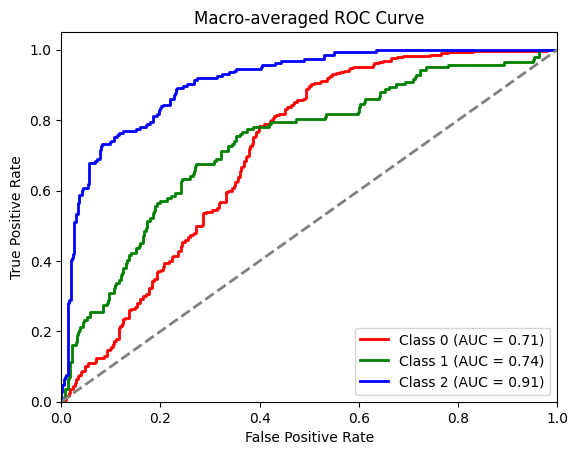

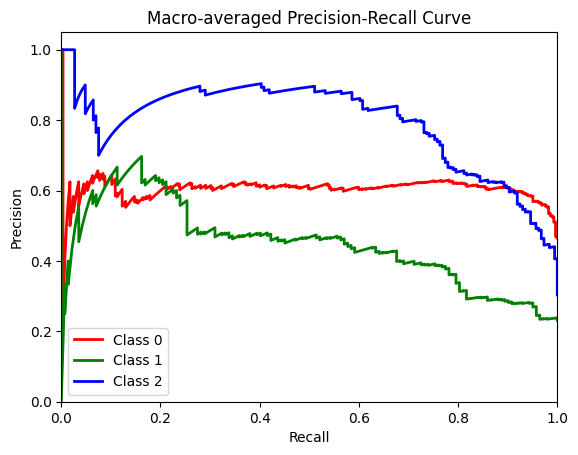

Overall Confusion Matrix:
[[279   0   6]
 [135   0   7]
 [ 88   0  98]]


In [11]:
kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds=10, epochs_per_fold=5, batch_size=512)

In [12]:
# @title Default title text
models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 